# Create Marchenko reflection response in ZARR file

In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import os
import shutil
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import dask.array as da
import pylops
import pylops_distributed
import dask
import zarr

from pylops.utils import dottest

Input parameters

In [3]:
os.environ["STORE_PATH"] = "/project/fsenter/mrava/Marchenko3D/"
zaar_filename = 'input3D_sub1.zarr'
zaar2_filename = 'input3D_sub2.zarr'
zaar4_filename = 'input3D_sub4.zarr'
zaar8_filename = 'input3D_sub8.zarr'

nfmax = 300 # max frequency for MDC (#samples)
nchunks = 150 # number of chunks in which R is segmented along frequency axis

## 3d data

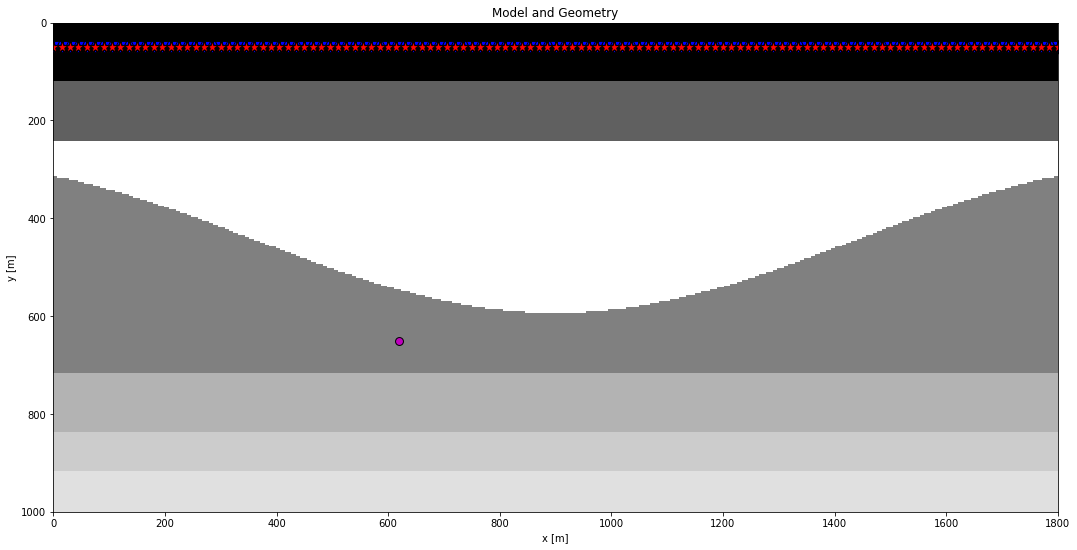

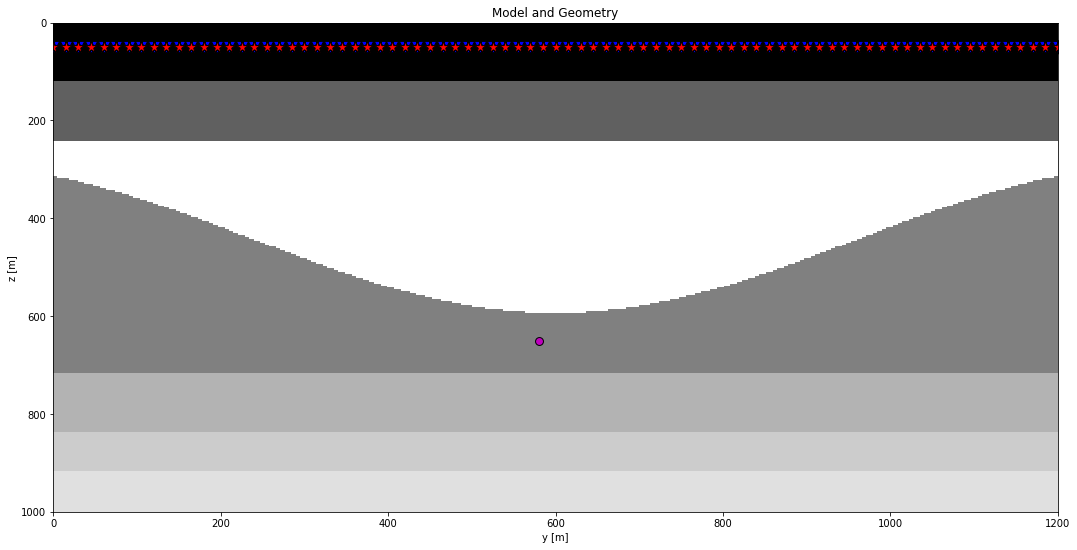

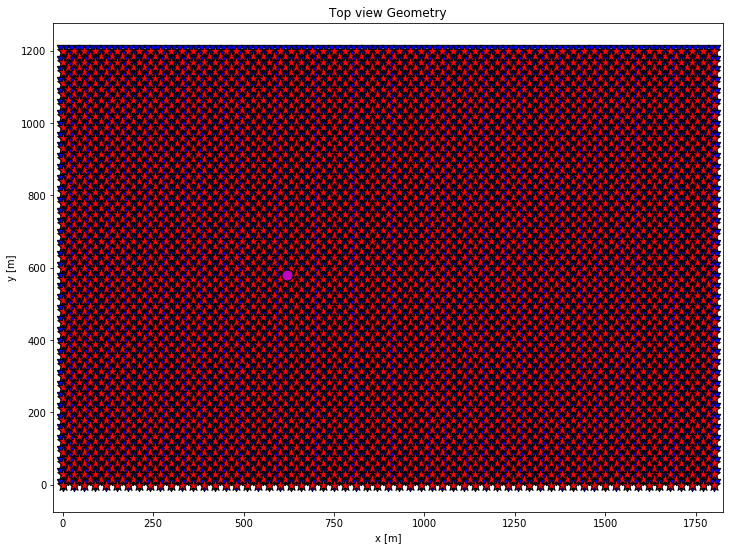

In [4]:
inputfile_aux = os.environ["STORE_PATH"]+'3DMarchenko_auxiliary_2.npz' 
inputdata_aux = np.load(inputfile_aux)

# Receivers
r = inputdata_aux['recs'].T
nr = r.shape[1]
dr = r[0,1]-r[0,0]

# Sources
s = inputdata_aux['srcs'].T
ns = s.shape[1]
ds = s[0,1]-s[0,0]

# Virtual points
vs = inputdata_aux['vs']

# Time axis
ot, dt, nt = 0, 2.5e-3, 601
t = np.arange(nt)*dt

# Density model
rho = inputdata_aux['rho']
z, x, y = inputdata_aux['z'], inputdata_aux['x'], inputdata_aux['y']

plt.figure(figsize=(18,9))
plt.imshow(rho[np.argmin(np.abs(x-vs[1]))].T, cmap='gray', extent = (x[0], x[-1], z[-1], z[0]))
plt.scatter(r[0, ::10],  r[2, ::10], marker='v', s=150, c='b', edgecolors='k')
plt.scatter(s[0, 5::10], s[2, 5::10], marker='*', s=150, c='r', edgecolors='k')
plt.scatter(vs[0], vs[2], marker='.', s=250, c='m', edgecolors='k')
plt.axis('tight')
plt.xlabel('x [m]'),plt.ylabel('y [m]'),plt.title('Model and Geometry')
plt.xlim(x[0], x[-1]);

plt.figure(figsize=(18,9))
plt.imshow(rho[np.argmin(np.abs(y-vs[0]))].T, cmap='gray', extent = (y[0], y[-1], z[-1], z[0]))
plt.scatter(r[1, ::10],  r[2, ::10], marker='v', s=150, c='b', edgecolors='k')
plt.scatter(s[1, 5::10], s[2, 5::10], marker='*', s=150, c='r', edgecolors='k')
plt.scatter(vs[1], vs[2], marker='.', s=250, c='m', edgecolors='k')
plt.axis('tight')
plt.xlabel('y [m]'),plt.ylabel('z [m]'),plt.title('Model and Geometry')
plt.xlim(y[0], y[-1]);

plt.figure(figsize=(12,9))
plt.scatter(r[0, ::2],  r[1, ::2], marker='v', s=150, c='b', edgecolors='k')
plt.scatter(s[0, ::2], s[1, ::2], marker='*', s=150, c='r', edgecolors='k')
plt.scatter(vs[0], vs[1], marker='.', s=500, c='m', edgecolors='k')
plt.axis('equal')
plt.xlabel('x [m]'),plt.ylabel('y [m]'),plt.title('Top view Geometry')
plt.xlim(x[0], x[-1]);

In [5]:
client = pylops_distributed.utils.backend.dask(hardware='multi', client='be-linrgsn079:8786')
client

Client Scheduler: tcp://be-linrgsn079:8786 Dashboard: http://be-linrgsn079:8787/status,Cluster Workers: 8 Cores: 96 Memory: 1.09 TB


In [6]:
client.restart()

Client Scheduler: tcp://be-linrgsn079:8786 Dashboard: http://be-linrgsn079:8787/status,Cluster Workers: 8 Cores: 96 Memory: 1.09 TB


### Data with no subsampling with dask

In [7]:
def write_concurrent(isrc_in, isrc_end, dzarr, nfmax, nr, nr_in_batch=100):
    Rfilename = '/project/fsenter/mrava/Marchenko3D/3DMarchenko_data_batch%d_%d.npz' % (isrc_in, isrc_end-1)
    print('Reading %s\n' % Rfilename)
    R = np.load(Rfilename)['data']
    print('Done reading %s, shape=%s\n' % (Rfilename, str(R.shape)))
    
    # define start and end indices of receiver batches
    irecs_in = np.arange(0, nr-1, nr_in_batch)
    irecs_end =  irecs_in + nr_in_batch
    if irecs_end[-1] != nr-1:
        irecs_end[-1] = nr-1
    
    # process and write batches...
    print('Start processing...')
    for irec_in, irec_end in zip(irecs_in, irecs_end):
        #print('Processing batch %d/%d' % (irec_in / nr_in_batch, len(irecs_in)))
        print('Processing %d-%d src batch, %d-%d rec batch' % (isrc_in, isrc_end, irec_in, irec_end))
        Rtwosided = np.concatenate((np.zeros(((isrc_end - isrc_in), (irec_end - irec_in), R.shape[2]-1)), 
                                    R[:, irec_in:irec_end]), axis=-1)
        Rtwosided_fft = np.fft.rfft(Rtwosided, 2*R.shape[2]-1, axis=-1)/np.sqrt(2*R.shape[2]-1)
        Rtwosided_fft = Rtwosided_fft[..., :nfmax]
        Rtwosided_fft = Rtwosided_fft.astype(np.complex64)
        
        #print('Writing %d-%d batch %d-%d' % (isrc_in, isrc_end, irec_in, irec_end))
        dzarr[isrc_in:isrc_end, int(irec_in):int(irec_end)] = Rtwosided_fft
        #print('Done writing %d-%d batch %d-%d' % (isrc_in, isrc_end, irec_in, irec_end))
        del Rtwosided, Rtwosided_fft
    del R
    return isrc_in

In [30]:
ns_batchs = 4
nr_batchs = 200
zaar_filepath = os.environ["STORE_PATH"]+zaar_filename

Rstore = zarr.DirectoryStore(zaar_filepath)
Rzaar = zarr.create(store=Rstore, overwrite=True, 
                    shape=(ns, nr, nfmax), 
                    chunks=(ns // ns_batchs, nr // nr_batchs, nfmax), 
                    #compressor=None,
                    synchronizer=zarr.ThreadSynchronizer(),
                    dtype=np.complex64)

Rzaar.info

Type,zarr.core.Array
Data type,complex64
Shape,"(9801, 9801, 300)"
Chunk shape,"(2450, 49, 300)"
Order,C
Read-only,False
Compressor,"Blosc(cname='lz4', clevel=5, shuffle=SHUFFLE, blocksize=0)"
Synchronizer type,zarr.sync.ThreadSynchronizer
Store type,zarr.storage.DirectoryStore
No. bytes,230543042400 (214.7G)
No. bytes stored,398


In [31]:
ns_in_batch = ns // ns_batchs
nr_in_batch = nr // nr_batchs

output = []
for ibatch in range(ns_batchs):
    isrc_start = ibatch * ns_in_batch
    isrc_end = (ibatch + 1) * ns_in_batch if ibatch < (ns_batchs - 1) else ns
    out = dask.delayed(write_concurrent)(isrc_start, isrc_end, Rzaar, nfmax, nr, nr_in_batch=nr_in_batch)
    output.append(out)
total = dask.delayed(sum)(output)

total.compute()

14700

In [32]:
Rzaar.info

Type,zarr.core.Array
Data type,complex64
Shape,"(9801, 9801, 300)"
Chunk shape,"(2450, 49, 300)"
Order,C
Read-only,False
Compressor,"Blosc(cname='lz4', clevel=5, shuffle=SHUFFLE, blocksize=0)"
Synchronizer type,zarr.sync.ThreadSynchronizer
Store type,zarr.storage.DirectoryStore
No. bytes,230543042400 (214.7G)
No. bytes stored,208191070519 (193.9G)


In [8]:
Rda = da.from_zarr(zaar_filepath)
Rda

plt.figure(figsize=(10, 10))
plt.imshow(np.abs(Rda[:,:,100].compute()))
plt.axis('tight');

NameError: name 'zaar_filepath' is not defined

### Data with subsampling=8

In [ ]:
Rda8 = Rda[::8, ::8]
Rda8 = Rda8.rechunk((ns//40, nr//40, nfmax))
Rda8

In [ ]:
zaar8_filename = 'input3D_sub8.zarr'
zaar8_filepath = os.environ["STORE_PATH"]+zaar8_filename

Rstore = zarr.DirectoryStore(zaar8_filepath)
da.to_zarr(Rda8, Rstore)

### Data with subsampling=4

In [63]:
Rda4 = Rda[::4, ::4]
Rda4 = Rda4.rechunk((ns//40, nr//40, nfmax))
Rda4

dask.array<rechunk-merge, shape=(2451, 2451, 300), dtype=complex64, chunksize=(245, 245, 300)>

In [64]:
zaar4_filename = 'input3D_sub4.zarr'
zaar4_filepath = os.environ["STORE_PATH"]+zaar4_filename

Rstore = zarr.DirectoryStore(zaar4_filepath)
da.to_zarr(Rda4, Rstore)

### Data with subsampling=2

In [68]:
Rda2 = Rda[::2, ::2]
Rda2 = Rda2.rechunk((ns//40, nr//40, nfmax))
Rda2

,Array,Chunk
Bytes,57.65 GB,144.06 MB
Shape,"(4901, 4901, 300)","(245, 245, 300)"
Count,6319 Tasks,441 Chunks
Type,complex64,numpy.ndarray


In [69]:
zaar2_filename = 'input3D_sub2.zarr'
zaar2_filepath = os.environ["STORE_PATH"]+zaar2_filename

Rstore = zarr.DirectoryStore(zaar2_filepath)
da.to_zarr(Rda2, Rstore)

In [37]:
client.close()

### Data with no subsampling with dask (f in first axis)

In [79]:
def write_concurrent(isrc_in, isrc_end, dzarr, nfmax, nr, nr_in_batch=100, irec_restart=0):
    Rfilename = '/project/fsenter/mrava/Marchenko3D/3DMarchenko_data_batch%d_%d.npz' % (isrc_in, isrc_end-1)
    print('Reading %s\n' % Rfilename)
    R = np.load(Rfilename)['data']
    print('Done reading %s, shape=%s\n' % (Rfilename, str(R.shape)))
    
    # define start and end indices of receiver batches
    irecs_in = np.arange(irec_restart, nr-1, nr_in_batch)
    irecs_end =  irecs_in + nr_in_batch
    if irecs_end[-1] != nr-1:
        irecs_end[-1] = nr-1
    print('irecs_in', irecs_in)
    
    # process and write batches...
    print('Start processing...')
    for irec_in, irec_end in zip(irecs_in, irecs_end):
        #print('Processing batch %d/%d' % (irec_in / nr_in_batch, len(irecs_in)))
        print('Processing %d-%d src batch, %d-%d rec batch' % (isrc_in, isrc_end, irec_in, irec_end))
        Rtwosided = np.concatenate((np.zeros(((isrc_end - isrc_in), (irec_end - irec_in), R.shape[2]-1)), 
                                    R[:, irec_in:irec_end]), axis=-1)
        Rtwosided_fft = np.fft.rfft(Rtwosided, 2*R.shape[2]-1, axis=-1)/np.sqrt(2*R.shape[2]-1)
        Rtwosided_fft = Rtwosided_fft[..., :nfmax]
        Rtwosided_fft = Rtwosided_fft.astype(np.complex64)
        
        #print('Writing %d-%d batch %d-%d' % (isrc_in, isrc_end, irec_in, irec_end))
        dzarr[:, int(irec_in):int(irec_end), isrc_in:isrc_end] = Rtwosided_fft.transpose(2, 1, 0)
        #print('Done writing %d-%d batch %d-%d' % (isrc_in, isrc_end, irec_in, irec_end))
        del Rtwosided, Rtwosided_fft
    del R
    return isrc_in

In [81]:
zaar_filename = 'input3D_sub1_ffirst.zarr'

nf_batchs = nfmax // 20
ns_batchs = 10
nr_batchs = 20
zaar_filepath = os.environ["STORE_PATH"]+zaar_filename

Rstore = zarr.DirectoryStore(zaar_filepath)
Rzaar = zarr.create(store=Rstore, overwrite=True, 
                    shape=(nfmax, nr, ns), 
                    chunks=(nfmax // nf_batchs,  nr // nr_batchs + 1, ns // ns_batchs + 1), 
                    #compressor=None,
                    synchronizer=zarr.ThreadSynchronizer(),
                    dtype=np.complex64)

Rzaar.info

Type,zarr.core.Array
Data type,complex64
Shape,"(300, 9801, 9801)"
Chunk shape,"(20, 491, 981)"
Order,C
Read-only,False
Compressor,"Blosc(cname='lz4', clevel=5, shuffle=SHUFFLE, blocksize=0)"
Synchronizer type,zarr.sync.ThreadSynchronizer
Store type,zarr.storage.DirectoryStore
No. bytes,230543042400 (214.7G)
No. bytes stored,397


In [82]:
ns_batchs = 4
nr_batchs = 20
ns_in_batch = ns // ns_batchs
nr_in_batch = nr // nr_batchs

output = []
for ibatch in range(ns_batchs):
    isrc_start = ibatch * ns_in_batch
    isrc_end = (ibatch + 1) * ns_in_batch if ibatch < (ns_batchs - 1) else ns
    out = dask.delayed(write_concurrent)(isrc_start, isrc_end, Rzaar, nfmax, nr, 
                                         nr_in_batch=nr_in_batch, irec_restart=0)
    output.append(out)
total = dask.delayed(sum)(output)

total.compute()

14700

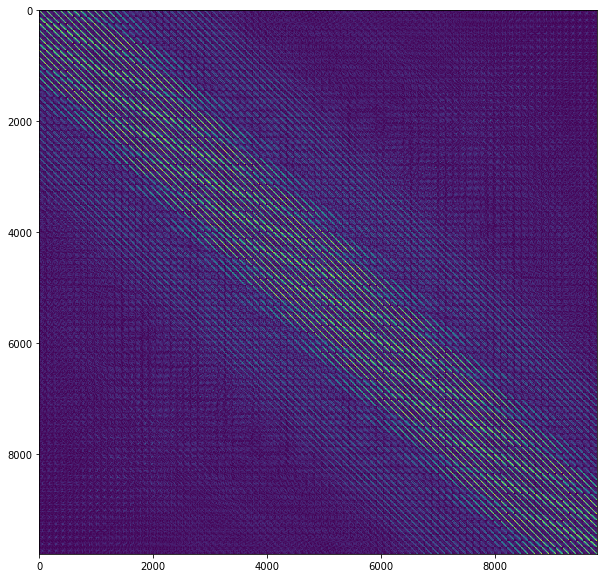

In [11]:
zaar_filename = 'input3D_sub1_ffirst.zarr'
zaar_filepath = os.environ["STORE_PATH"]+zaar_filename

Rda = da.from_zarr(zaar_filepath)

plt.figure(figsize=(10, 10))
plt.imshow(np.abs(Rda[100].compute()))
plt.axis('tight');

In [12]:
Rda

,Array,Chunk
Bytes,230.54 GB,77.07 MB
Shape,"(300, 9801, 9801)","(20, 491, 981)"
Count,3001 Tasks,3000 Chunks
Type,complex64,numpy.ndarray


### Data with subsampling=8 (f in first axis)

In [22]:
Rda8 = Rda[:, ::8, ::8]
Rda8 = Rda8.rechunk((nfmax // nf_batchs,  nr // 20, ns // 20))
Rda8

dask.array<rechunk-merge, shape=(300, 1226, 1226), dtype=complex64, chunksize=(20, 490, 490)>

In [23]:
zaar8_filename = 'input3D_sub8_ffirst.zarr'
zaar8_filepath = os.environ["STORE_PATH"]+zaar8_filename

Rstore = zarr.DirectoryStore(zaar8_filepath)
da.to_zarr(Rda8, Rstore)

### Data with subsampling=4 (f in first axis)

In [24]:
Rda4 = Rda[:, ::4, ::4]
Rda4 = Rda4.rechunk((nfmax // nf_batchs,  nr // 20, ns // 20))
Rda4

dask.array<rechunk-merge, shape=(300, 2451, 2451), dtype=complex64, chunksize=(20, 490, 490)>

In [25]:
zaar4_filename = 'input3D_sub4_ffirst.zarr'
zaar4_filepath = os.environ["STORE_PATH"]+zaar4_filename

Rstore = zarr.DirectoryStore(zaar4_filepath)
da.to_zarr(Rda4, Rstore)

In [ ]:
### Data with subsampling=2 (f in first axis)

In [30]:
Rda2 = Rda[:, ::2, ::2]
Rda2 = Rda2.rechunk((nfmax // nf_batchs,  nr // 20, ns // 20))
Rda2

,Array,Chunk
Bytes,57.65 GB,38.42 MB
Shape,"(300, 4901, 4901)","(20, 490, 490)"
Count,15766 Tasks,1815 Chunks
Type,complex64,numpy.ndarray


In [31]:
zaar2_filename = 'input3D_sub2_ffirst.zarr'
zaar2_filepath = os.environ["STORE_PATH"]+zaar2_filename

Rstore = zarr.DirectoryStore(zaar2_filepath)
da.to_zarr(Rda2, Rstore)

In [32]:
client.close()